In [1]:
import sys
import os
from dotenv import load_dotenv
import warnings

# Configurar el Path del Proyecto (para neuro_agent)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Cargar Variables de Entorno
load_dotenv(os.path.join(project_root, ".env"), override=True)

# Habilitar recarga automática
%load_ext autoreload
%autoreload 2

# Silenciar warnings específicos de LangSmith
warnings.filterwarnings("ignore", message="LangSmith now uses UUID v7")


In [2]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="LangSmith now uses UUID v7", 
    category=UserWarning,
)

# Deep Agent for Research

## Overview 

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

Now, we can put everything we have learned together:

* We will use **TODOs** to keep track of tasks. 
* We will use **files** to store raw tool call results. 
* We will **delegate research tasks to sub-agents** for context isolation. 

## Search Tool 

We'll build a search tool that offloads raw contents to files and returns only a summary to the agent. This is a common pattern for long-running agent trajectories, [as we've seen with Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)! 

### Core Components

1. **Search Execution (`run_tavily_search`)**: Performs the actual web search using Tavily API with configurable parameters for results count and topic filtering.

2. **Content Summarization (`summarize_webpage_content`)**: Uses a lightweight model (GPT-4o-mini) to generate structured summaries of webpage content, producing both a descriptive filename and key learnings summary.

3. **Result Processing (`process_search_results`)**: Fetches full webpage content via HTTP, converts HTML to markdown using `markdownify`, and generates summaries for each result.

4. **Context Offloading (`tavily_search` tool)**: The main tool that:
   - Executes search and processes results
   - Saves full content to files in agent state (context offloading)
   - Returns only minimal summaries to the agent (prevents context spam)
   - Uses LangGraph `Command` to update both files and messages

5. **Strategic Thinking (`think_tool`)**: Provides a structured reflection mechanism for agents to analyze findings, assess gaps, and plan next steps in their research workflow.

This architecture solves the token efficiency problem by storing detailed search results in files while keeping the agent's working context minimal and focused.

<div style="background-color: #fff3b0; padding: 10px; border-radius: 4px;">
<b>Note:</b>  
The <code>create_react_agent</code> was moved from the LangGraph library to the LangChain library and renamed to <code>create_agent</code> in the 1.0 code release post-filming. There are slight changes to the imports and code to accommodate this. The video may display the previous configuration.
</div>

In [3]:
%%writefile ../neuro_agent/src/shared/tools/research.py
"""Research Tools."""
import os
from datetime import datetime
import uuid, base64
import httpx
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import tool
from langchain_core.tools import InjectedToolArg, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing import Annotated, Literal, Optional, Any
from langchain_aws import ChatBedrockConverse

summarization_model = ChatBedrockConverse(model="us.amazon.nova-pro-v1:0", region_name="us-east-1", temperature=0.0)
from deep_agents_from_scratch.prompts import SUMMARIZE_WEB_SEARCH
from neuro_agent.src.shared.state import AgentState
DeepAgentState = AgentState

tavily_client = TavilyClient()
HTTPX_CLIENT = httpx.Client(timeout=30.0)

class Summary(BaseModel):
    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")

def get_today_str() -> str:
    return datetime.now().strftime("%a %b %-d, %Y")

def run_tavily_search(search_query: str, max_results: int = 1, topic="general", include_raw_content=True) -> dict:
    return tavily_client.search(search_query, max_results=max_results, include_raw_content=include_raw_content, topic=topic)

def summarize_webpage_content(webpage_content: str) -> Summary:
    try:
        structured_model = summarization_model.with_structured_output(Summary)
        return structured_model.invoke([HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(webpage_content=webpage_content, date=get_today_str()))])
    except Exception:
        return Summary(filename="search_result.md", summary=webpage_content[:1000])

def process_search_results(results: dict) -> list[dict]:
    processed_results = []
    for result in results.get('results', []):
        url = result['url']
        try:
            response = HTTPX_CLIENT.get(url)
            if response.status_code == 200:
                raw_content = markdownify(response.text)
                summary_obj = summarize_webpage_content(raw_content)
            else:
                raw_content = result.get('raw_content', '')
                summary_obj = Summary(filename="URL_error.md", summary=result.get('content', 'Error reading URL.'))
        except Exception:
            raw_content = result.get('raw_content', '')
            summary_obj = Summary(filename="error.md", summary=result.get('content', 'Connection error.'))
        uid = base64.urlsafe_b64encode(uuid.uuid4().bytes).rstrip(b"=").decode("ascii")[:8]
        name, ext = os.path.splitext(summary_obj.filename)
        summary_obj.filename = f"{name}_{uid}{ext}"
        processed_results.append({'url': url, 'title': result['title'], 'summary': summary_obj.summary, 'filename': summary_obj.filename, 'raw_content': raw_content})
    return processed_results

@tool
def tavily_search(
    query: str, 
    state: Annotated[Optional[dict], InjectedState] = None, 
    tool_call_id: Annotated[Optional[str], InjectedToolCallId] = None, 
    max_results: Annotated[int, InjectedToolArg] = 1, 
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general"
) -> Command:
    """Search web and save results."""
    if state is None or tool_call_id is None:
        return Command(update={"messages": [ToolMessage("Error: Missing injected arguments", tool_call_id="")]})

    res = run_tavily_search(query, max_results=max_results, topic=topic)
    processed = process_search_results(res)
    files = state.get("files", {})
    summaries = []
    for r in processed:
        fn = r['filename']
        files[fn] = f"# {r['title']}\n\n{r['summary']}\n\n{r['raw_content']}"
        summaries.append(f"- {fn}: {r['summary']}...")
    return Command(update={"files": files, "messages": [ToolMessage("🔍 Results:\n" + "\n".join(summaries), tool_call_id=tool_call_id)]})

@tool
def think_tool(reflection: str) -> str:
    """Record a reflection or thought process."""
    return f"Reflection recorded: {reflection}"


Overwriting ../neuro_agent/src/shared/tools/research.py


## Deep Agent

Now, we can just apply all of our prior learnings: 

* We'll give the researcher a `think_tool` and our `search_tool` above.
* We'll give our parent agent file tools, a `think_tool`, and a `task` tool. 

In [4]:
from datetime import datetime
from IPython.display import Image, display
from utils import show_prompt, stream_agent

# Imports de neuro_agent
from neuro_agent.src.shared.state import AgentState
from neuro_agent.src.shared.tools.research import tavily_search, think_tool, get_today_str
from neuro_agent.src.shared.tools.delegation import create_subagent_tool
from neuro_agent.src.shared.tools.filesystem import ls, read_file, write_file
from neuro_agent.src.shared.tools.planning import write_todos, read_todos

# Import de create_agent (actualizado 1.0)
from langchain.agents import create_agent

# Prompts (importados de deep_agents_from_scratch)
from deep_agents_from_scratch.prompts import (
    FILE_USAGE_INSTRUCTIONS, RESEARCHER_INSTRUCTIONS, SUBAGENT_USAGE_INSTRUCTIONS, TODO_USAGE_INSTRUCTIONS
)

from langchain_aws import ChatBedrockConverse
model = ChatBedrockConverse(model="us.amazon.nova-2-lite-v1:0", region_name="us-east-1", temperature=0.0)

max_concurrent_research_units = 3
max_researcher_iterations = 3

sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]

# Configuración del Sub-Agente Researcher
researcher_config = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": ["tavily_search", "think_tool"]
}

# Herramienta de delegación usando el factory de neuro_agent
task_tool = create_subagent_tool(
    tools=sub_agent_tools,
    subagents=[researcher_config],
    llm=model,
    state_schema=AgentState
)

all_tools = sub_agent_tools + built_in_tools + [task_tool]

SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
    max_concurrent_research_units=max_concurrent_research_units,
    max_researcher_iterations=max_researcher_iterations,
    date=datetime.now().strftime("%a %b %-d, %Y")
)

INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_INSTRUCTIONS
)


In [5]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 1-2 search tool calls maximum                                                        │
│  - **Normal queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Very Complex queries**: Use up to 5 search tool calls maximum                                              │
│  - **Always stop**: After 5 search tool calls if you c

In [6]:
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # TODO MANAGEMENT                                                                                              │
│  ⛔ MANDATORY EXECUTION CONTRACT — The TODO list is NOT optional.                                               │
│                                                                                                                 │
│  ## Rules (Non-Negotiable)                                                                                      │
│  1. ALWAYS create a TODO plan using write_todos as your FIRST action on ANY user request.                       │
│  2. EVERY step in the TODO MUST be executed using the appropriate tool — NO exceptions.                         │
│  3. NEVER answer from memory alone — you MUST use tools to complete each step.                                  │
│  4. After executing a step, mark it as completed using write_todos.                                             │
│  5. Use read_todos frequently to verify your progress and remind yourself of remaining steps.                   │
│  6. You CANNOT finish until ALL steps show status "completed".                                                  │
│  7. The system will BLOCK you from ending if steps remain incomplete.                                           │
│  8. If you have already executed tools in this turn, mark the corresponding steps as 'completed' in your        │
│  initial plan.                                                                                                  │
│                                                                                                                 │
│  ## Workflow                                                                                                    │
│  1. Create your TODO plan (write_todos)                                                                         │
│  2. Execute step 1 using the appropriate tool                                                                   │
│  3. Mark step 1 completed (write_todos)                                                                         │
│  4. Read TODOs to check progress (read_todos)                                                                   │
│  5. Repeat for each remaining step                                                                              │
│  6. Only provide your final answer AFTER all TODOs are completed                                                │
│                                                                                                                 │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│  IMPORTANT: The system audits your execution. Skipped steps are flagged. Follow the script.                     │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # FILE SYSTEM USAGE                                                                                            │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## ⚠️ ABSOLUTE FIRST STEP - NO EXCEPTIONS ⚠️          

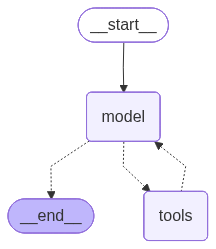

In [7]:
# Create agent using the unified create_agent factory (1.0 version)
agent = create_agent(
    model, all_tools, system_prompt=INSTRUCTIONS, state_schema=AgentState
)

# Show the agent graphs
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))


In [8]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: tooluse_qkRgV9vdmcolEjfMfVKfJd                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "user_request.md",                                                                               │
│   "content": "Give me an overview of Model Context Protocol (MCP)."                                             │
│ }                                                                                                               │
│    ID: tooluse_5DyHvDzPVCjJVSRNIwMgTJ                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file user_request.md                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research and provide an overview of Model Context Protocol (MCP)",                            │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: tooluse_rRTUCrDnERAqp19796GYUy                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated TODO list (Total items: 1).                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research and provide an overview of Model Context Protocol (MCP)",                            │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: tooluse_qK0XSU1VUN6sfbxhmpSxUI                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ []                                                                                                              │
│                                                                                                                 │
│ ✅ Task automatically marked as completed.                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I need to gather information about Model Context Protocol (MCP). Let me search for this topic  │
│ to get a comprehensive overview."                                                                               │
│ }                                                                                                               │
│    ID: tooluse_rWTbyJSPXEq1m4acVEVUR0                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I need to gather information about Model Context Protocol (MCP). Let me search for this    │
│ topic to get a comprehensive overview.                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP overview"                                                                │
│ }                                                                                                               │
│    ID: tooluse_OkMroQNqtciDRxBXVY4qzO                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 🔍 Results:                                                                                                     │
│ - URL_error_pwmS4EM9.md: ##### About MCP. ##### Develop with MCP. * Connect to local MCP servers. MCP (Model    │
│ Context Protocol) is an open-source standard for connecting AI applications to external systems. Using MCP, AI  │
│ applications like Claude or ChatGPT can connect to data sources (e.g. local files, databases), tools (e.g.      │
│ search engines, calculators) and workflows (e.g. specialized prompts)—enabling them to access key information   │
│ and perform tasks. Just as USB-C provides a standardized way to connect electronic devices, MCP provides a      │
│ standardized way to connect AI applications to external systems. * **Developers**: MCP reduces development time │
│ and complexity when building, or integrating with, an AI application or agent. * **AI applications or agents**: │
│ MCP provides access to an ecosystem of data sources, tools and apps which will enhance capabilities and improve │
│ the end-user experience. * **End-users**: MCP results in more capable AI applications or agents which can       │
│ access your data and take actions on your behalf when necessary. Develop applications that connect to MCP       │
│ servers....                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Let me search for more detailed information about MCP to provide a comprehensive overview."    │
│ }                                                                                                               │
│    ID: tooluse_gsgFjEZandzQ5UcpI63Lut                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: Let me search for more detailed information about MCP to provide a comprehensive overview. │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP detailed explanation"                                                    │
│ }                                                                                                               │
│    ID: tooluse_GVeQRSmJE3E1sjiK9S6gQr                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 🔍 Results:                                                                                                     │
│ - URL_error_637tUb4m.md: ##### About MCP. ##### Develop with MCP. * Connect to local MCP servers. MCP (Model    │
│ Context Protocol) is an open-source standard for connecting AI applications to external systems. Using MCP, AI  │
│ applications like Claude or ChatGPT can connect to data sources (e.g. local files, databases), tools (e.g.      │
│ search engines, calculators) and workflows (e.g. specialized prompts)—enabling them to access key information   │
│ and perform tasks. Just as USB-C provides a standardized way to connect electronic devices, MCP provides a      │
│ standardized way to connect AI applications to external systems. * **Developers**: MCP reduces development time │
│ and complexity when building, or integrating with, an AI application or agent. * **AI applications or agents**: │
│ MCP provides access to an ecosystem of data sources, tools and apps which will enhance capabilities and improve │
│ the end-user experience. * **End-users**: MCP results in more capable AI applications or agents which can       │
│ access your data and take actions on your behalf when necessary. Develop applications that connect to MCP       │
│ servers....                                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP benefits and use cases"                                                  │
│ }                                                                                                               │
│    ID: tooluse_CpRzmZowWTXpwkcp5s4EPP                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 🔍 Results:                                                                                                     │
│ - code_execution_mcp_efficiency_cJtH9KoF.md: This blog post discusses using code execution with the Model       │
│ Context Protocol (MCP) to improve AI agent efficiency. Key points include reducing token consumption by loading │
│ tools on demand, filtering data in code before returning results, and enabling more powerful control flow and   │
│ privacy-preserving operations....                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Let me search for MCP architecture and technical details to provide a more comprehensive       │
│ overview."                                                                                                      │
│ }                                                                                                               │
│    ID: tooluse_kBmTOpSihBBOVNbxRYhXE8                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: Let me search for MCP architecture and technical details to provide a more comprehensive   │
│ overview.                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP architecture technical details"                                          │
│ }                                                                                                               │
│    ID: tooluse_MuhDweAJwD7qTa6CPzK2WD                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 🔍 Results:                                                                                                     │
│ - mcp_protocol_overview_3I0Iyfho.md: Overview of the Model Context Protocol (MCP) covering scope, concepts,     │
│ layers, data layer protocol, and examples. Key information includes lifecycle management, primitives (tools,    │
│ resources, prompts), and real-time notifications....                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "mcp_protocol_overview_3I0Iyfho.md"                                                              │
│ }                                                                                                               │
│    ID: tooluse_oSUTqtuRWHzrLbjrMFKZuH                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  # Architecture overview - Model Context Protocol                                                        │
│      2                                                                                                          │
│      3  Overview of the Model Context Protocol (MCP) covering scope, concepts, layers, data layer protocol, and │
│ examples. Key information includes lifecycle management, primitives (tools, resources, prompts), and real-time  │
│ notifications.                                                                                                  │
│      4                                                                                                          │
│      5  Architecture overview - Model Context Protocol                                                          │
│      6                                                                                                          │
│      7  [Skip to main content](#content-area)                                                                   │
│      8                                                                                                          │
│      9  [Model Context Protocol home                                                                            │
│ page!(https://mintcdn.com/mcp/4ZXF1PrDkEaJvXpn/logo/light.svg?fit=max&auto=format&n=4ZXF1PrDkEaJvXpn&q=85&s=449 │
│ 8cb8a57d574005f3dca62bdd49c95)!(https://mintcdn.com/mcp/4ZXF1PrDkEaJvXpn/logo/dark.svg?fit=max&auto=format&n=4Z │
│ XF1PrDkEaJvXpn&q=85&s=c0687c003f8f2cbdb24772ab4c8a522c)](/)                                                     │
│     10                                                                                                          │
│     11  Search...                                                                                               │
│     12                                                                                                          │
│     13  ⌘K                                                                                                      │
│     14                                                                                                          │
│     15  * [Blog](https://blog.modelcontextprotocol.io)                                                          │
│     16  * [GitHub](https://github.com/modelcontextprotocol)                                                     │
│     17                                                                                                          │
│     18  Search...                                                                                               │
│     19                                                                                                          │
│     20  Navigation                                                                                              │
│     21                                                                                                          │
│     22  About MCP                                                                                               │
│     23                                                                                                          │
│     24  Architecture overview                                                                                   │
│     25                                                                                                          │
│     26                                                                                                          │
│ [Documentation](/docs/getting-started/intro)[Specification](/specification/2025-11-25)[Registry](/registry/abou │
│ t)[Community](/community/contributing)                                                                          │
│     27                                                 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Create a comprehensive overview of Model Context Protocol (MCP) based on the research         │
│ findings",                                                                                                      │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: tooluse_xz01t3yvgbQbvm8HmBuj6V                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated TODO list (Total items: 1).                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Now I have gathered sufficient information about Model Context Protocol (MCP). Let me analyze  │
│ the findings and create a comprehensive overview based on the architecture document and other sources."         │
│ }                                                                                                               │
│    ID: tooluse_qRMHmmuYgJuGHktblE2Wyj                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: Now I have gathered sufficient information about Model Context Protocol (MCP). Let me      │
│ analyze the findings and create a comprehensive overview based on the architecture document and other sources.  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ## Model Context Protocol (MCP) Overview                                                                        │
│                                                                                                                 │
│ ### What is MCP?                                                                                                │
│                                                                                                                 │
│ Model Context Protocol (MCP) is an **open-source standard** for connecting AI applications to external systems. │
│ It enables AI applications like Claude or ChatGPT to access data sources, tools, and workflows, allowing them   │
│ to retrieve key information and perform tasks. Think of it as a standardized way to connect AI applications to  │
│ external systems - similar to how USB-C provides a standardized way to connect electronic devices.              │
│                                                                                                                 │
│ ### Core Participants                                                                                           │
│                                                                                                                 │
│ MCP follows a client-server architecture with three key participants:                                           │
│                                                                                                                 │
│ 1. **MCP Host**: The AI application that coordinates and manages one or more MCP clients (e.g., Visual Studio   │
│ Code, Claude Desktop)                                                                                           │
│ 2. **MCP Client**: A component that maintains a connection to an MCP server and obtains context from the server │
│ for the MCP host                                                                                                │
│ 3. **MCP Server**: A program that provides context to MCP clients (can run locally or remotely)                 │
│                                                                                                                 │
│ ### Architecture Layers                                                                                         │
│                                                                                                                 │
│ MCP consists of two main layers:                                                                                │
│                                                                                                                 │
│ 1. **Data Layer**: Implements a JSON-RPC 2.0 based exchange protocol that defines message structure and         │
│ semantics                                                                                                       │
│    - Lifecycle management                                                                                       │
│    - Server features (tools, resources, prompts)                                                                │
│    - Client features (sampling, elicitation, logging)                                                           │
│    - Utility features (notifications, progress tracking)                                                        │
│                                                                                                                 │
│ 2. **Transport Layer**: Manages communication channels and authentication                                       │
│    - **Stdio transport**: Uses standard input/output streams for direct process communication (local servers)   │
│    - **Streamable HTTP transport**: Uses HTTP POST with optional Server-Sent Events (remote servers)            │
│                                                        

Trace: 
https://smith.langchain.com/public/3a389ec6-8e6e-4f9e-9a82-0d0a9569e6f8/r
<!-- https://smith.langchain.com/public/1df7a10e-1465-499c-a3e0-86c1d5429324/r -->

## Using the Deep Agent Package

Now you understand the underlying patterns! 

You can [use the `deepagents` package](
https://github.com/hwchase17/deepagents) as a simple abstraction:

* It include the file system tools
* It includes the todo tool
* It includes the task tool

You only need to supply the sub-agent and any tools you want the sub-agent to use.

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import SystemMessage

def create_neuro_agent(model, tools, system_prompt, checkpointer):
    workflow = StateGraph(AgentState)
    model_with_tools = model.bind_tools(tools)
    def agent_node(state: AgentState):
        messages = state["messages"]
        if system_prompt:
            messages = [SystemMessage(content=system_prompt)] + messages
        return {"messages": [model_with_tools.invoke(messages)]}
    workflow.add_node("agent", agent_node)
    workflow.add_node("tools", ToolNode(tools))
    workflow.add_edge(START, "agent")
    def should_continue(state: AgentState):
        return "tools" if state["messages"][-1].tool_calls else END
    workflow.add_conditional_edges("agent", should_continue, ["tools", END])
    workflow.add_edge("tools", "agent")
    return workflow.compile(checkpointer=checkpointer)

checkpointer = DynamoDBSaver(table_name="LangGraphCheckpoints")
agent = create_neuro_agent(model, all_tools, INSTRUCTIONS, checkpointer)
print("✅ NeuroAgent Assembled.")


In [ ]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an very brief overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

Trace: 
https://smith.langchain.com/public/1d626d81-a102-4588-a2fb-cab40a7271f1/r
<!-- https://smith.langchain.com/public/1ae2d7f6-f901-4ebd-b6c3-6657a55f88ae/r -->